# Weather Image Classifier

This notebook demonstrates how to train and use an EfficientNetB0 model for weather classification.
The model can classify images into 4 categories: Cloudy, Rain, Shine, and Sunrise.

## 1. Import Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


## 2. Dataset Configuration

In [2]:
# Dataset paths
dataset_path = "../indabax_south_sudan_intermediate"
train_dir = os.path.join(dataset_path, "weather_dataset")
test_dir = os.path.join(dataset_path, "test")

# Class names
CLASS_NAMES = ['Cloudy', 'Rain', 'Shine', 'Sunrise']

# Check if dataset exists
if os.path.exists(train_dir):
    print(f"Training directory found: {train_dir}")
    print(f"Classes in dataset: {os.listdir(train_dir)}")
else:
    print(f"Training directory not found: {train_dir}")
    print("Please ensure your dataset is in the correct location.")

Training directory found: ../indabax_south_sudan_intermediate\weather_dataset
Classes in dataset: ['Cloudy', 'Rain', 'Shine', 'Sunrise']


## 3. Load and Explore Dataset

In [3]:
# Create datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=123
)

class_names = train_dataset.class_names
print(f"Found classes: {class_names}")
print(f"Number of training batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}")

Found 1125 files belonging to 4 classes.
Using 900 files for training.
Found 1125 files belonging to 4 classes.
Using 225 files for validation.
Found classes: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Number of training batches: 29
Number of validation batches: 8


## 4. Visualize Sample Images

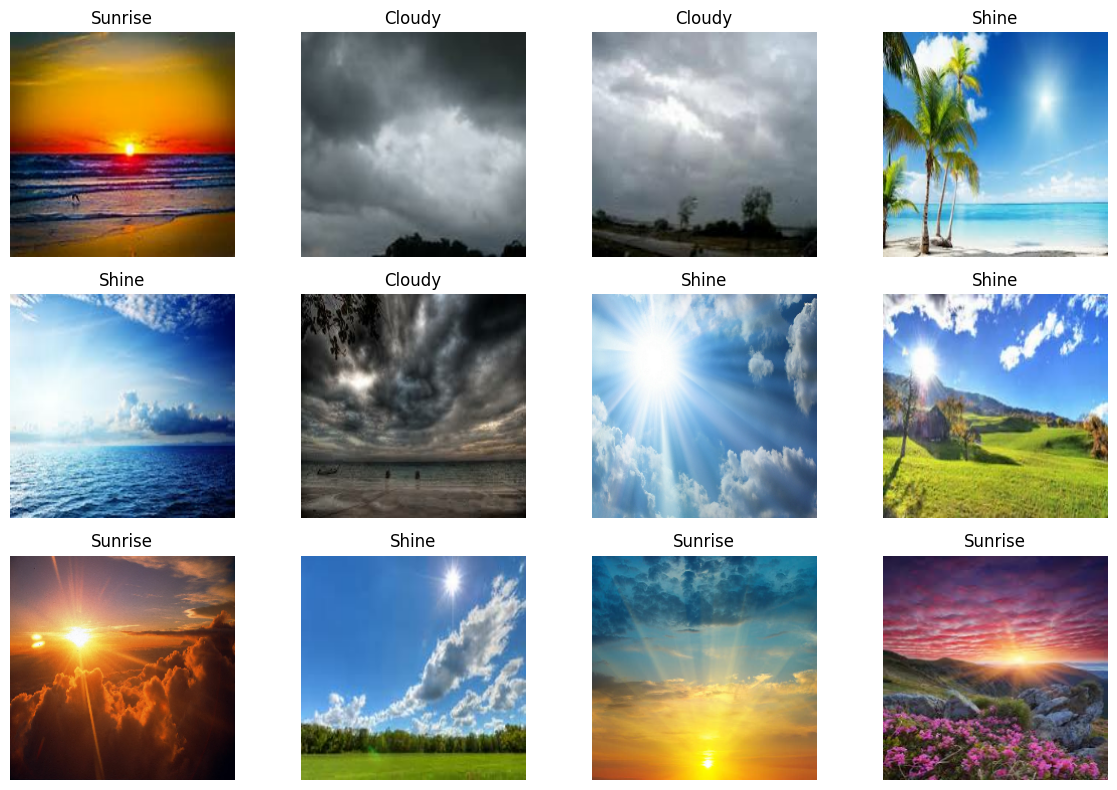

In [4]:
plt.figure(figsize=(12, 8))
for images, labels in train_dataset.take(1):
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

## 5. Create Model Architecture

In [5]:
def create_model(num_classes):
    """Create EfficientNetB0 model for weather classification"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
model = create_model(len(class_names))
print(f"Model created with {len(class_names)} classes")
model.summary()

Model created with 4 classes


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 6. Data Augmentation and Preprocessing

In [6]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Apply augmentation and optimization
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

print("Data augmentation and preprocessing applied")

Data augmentation and preprocessing applied


## 7. Train the Model

In [9]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5, 
        restore_best_weights=True,
        monitor='val_accuracy'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=3,
        factor=0.5,
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '../best_weather_model.h5',
        save_best_only=True,
        monitor='val_accuracy'
    )
]

# Compile the model with the correct loss function
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use this for integer labels
    metrics=['accuracy']
)


# Train the model
print("Starting training...")
EPOCHS = 20

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save('../weather_model.h5')
print("Model saved as 'weather_model.h5'")

Starting training...
Epoch 1/20


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.6765 - loss: 0.8476

29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 876ms/step - accuracy: 0.6806 - loss: 0.8386 - val_accuracy: 0.9378 - val_loss: 0.2288 - learning_rate: 0.0010
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9541 - loss: 0.1633

29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.9538 - loss: 0.1634 - val_accuracy: 0.9422 - val_loss: 0.1502 - learning_rate: 0.0010
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9468 - loss: 0.1514

29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.9470 - loss: 0.1505 - val_accuracy: 0.9511 - val_loss: 0.1331 - learning_rate: 0.0010
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9798 - loss: 0.0816

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 688ms/step - accuracy: 0.9794 - loss: 0.0823 - val_accuracy: 0.9556 - val_loss: 0.1265 - learning_rate: 0.0010
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 724ms/step - accuracy: 0.9616 - loss: 0.1020 - val_accuracy: 0.9556 - val_loss: 0.1360 - learning_rate: 0.0010
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9690 - loss: 0.0894

29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 795ms/step - accuracy: 0.9689 - loss: 0.0897 - val_accuracy: 0.9644 - val_loss: 0.1308 - learning_rate: 0.0010
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9752 - loss: 0.0742

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 686ms/step - accuracy: 0.9751 - loss: 0.0744 - val_accuracy: 0.9689 - val_loss: 0.1365 - learning_rate: 0.0010
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 672ms/step - accuracy: 0.9824 - loss: 0.0661 - val_accuracy: 0.9600 - val_loss: 0.1186 - learning_rate: 5.0000e-04
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 677ms/step - accuracy: 0.9781 - loss: 0.0627 - val_accuracy: 0.9644 - val_loss: 0.1318 - learning_rate: 5.0000e-04
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 684ms/step - accuracy: 0.9661 - loss: 0.0747 - val_accuracy: 0.9600 - val_loss: 0.1341 - learning_rate: 5.0000e-04
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 683ms/step - accuracy: 0.9777 - loss: 0.0683 - val_accuracy: 0.9556 - val_loss: 0.1299 - learning_rate: 5.0000e-04
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 690ms/step - accuracy: 0.9790 - loss: 0.0586 - val_accuracy: 0.9644 - val_loss: 0.1280 - learning_rate: 2.5000e-04


Model saved as 'weather_model.h5'


## 8. Visualize Training Results

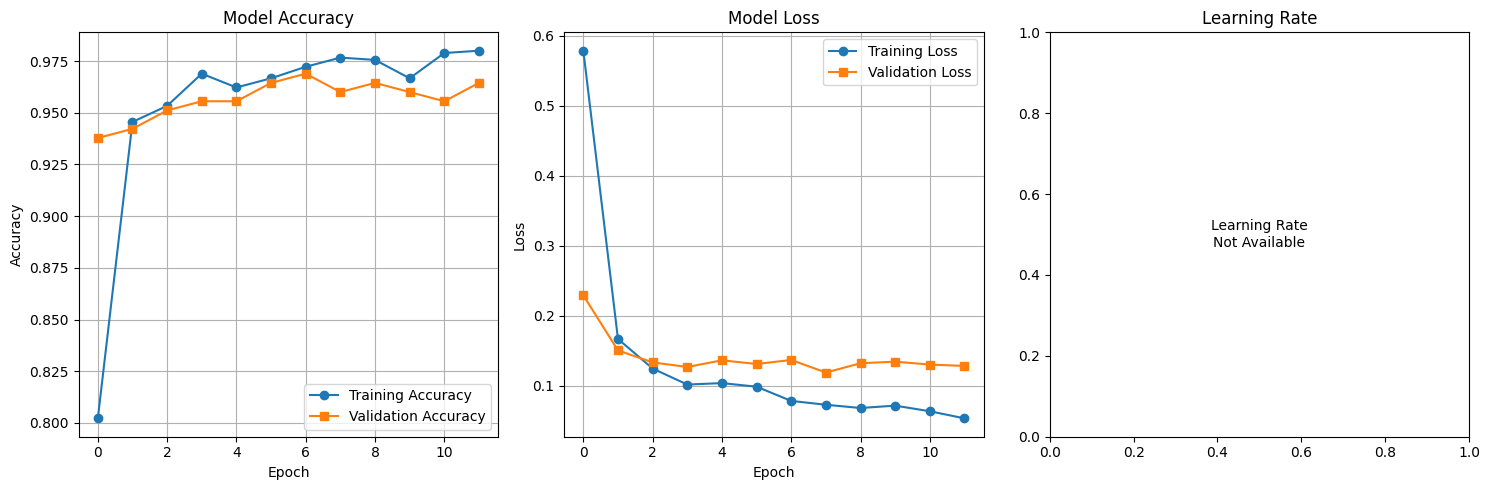

In [10]:
# Plot training history
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Learning rate plot (if available)
plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], label='Learning Rate', marker='o')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'Learning Rate\nNot Available', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Learning Rate')

plt.tight_layout()
plt.savefig('../training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Evaluate on Test Dataset

In [11]:
# Test on test dataset if available
if os.path.exists(test_dir):
    test_dataset = image_dataset_from_directory(
        test_dir,
        image_size=(224, 224),
        batch_size=32,
        shuffle=False
    )
    
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
else:
    print("Test directory not found")

Found 226 files belonging to 4 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 486ms/step - accuracy: 0.9854 - loss: 0.0627

Test Results:
Test Loss: 0.0775
Test Accuracy: 0.9779


## 10. Image Prediction Functions

In [12]:
def preprocess_image(img_path):
    """Preprocess image for prediction"""
    img = Image.open(img_path)
    
    # Resize image to 224x224 (EfficientNetB0 input size)
    img = img.resize((224, 224))
    
    # Convert to RGB if needed
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert to numpy array and normalize
    img_array = np.array(img) / 255.0
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array, img

def predict_weather(img_path):
    """Predict weather from image path"""
    processed_img, original_img = preprocess_image(img_path)
    predictions = model.predict(processed_img, verbose=0)
    
    # Get predicted class and confidence
    predicted_class_idx = np.argmax(predictions[0])
    confidence = float(predictions[0][predicted_class_idx])
    predicted_class = class_names[predicted_class_idx]
    
    # Get all predictions for display
    all_predictions = {}
    for i, class_name in enumerate(class_names):
        all_predictions[class_name] = float(predictions[0][i])
    
    return predicted_class, confidence, all_predictions, original_img

def plot_prediction(img_path):
    """Plot image with prediction results"""
    predicted_class, confidence, all_predictions, img = predict_weather(img_path)
    
    plt.figure(figsize=(12, 5))
    
    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2%}')
    plt.axis('off')
    
    # Display prediction probabilities
    plt.subplot(1, 2, 2)
    classes = list(all_predictions.keys())
    probabilities = list(all_predictions.values())
    
    bars = plt.bar(classes, probabilities)
    plt.title('Prediction Probabilities')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    
    # Highlight the predicted class
    max_idx = probabilities.index(max(probabilities))
    bars[max_idx].set_color('red')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class, confidence, all_predictions

print("Prediction functions defined successfully!")

Prediction functions defined successfully!


## 11. Model Information and Summary

In [15]:
# Display final training results
print("=" * 50)
print("TRAINING COMPLETE")
print("=" * 50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Number of Epochs Trained: {len(history.history['accuracy'])}")
print(f"Model saved to: weather_model.h5")
print(f"Classes: {class_names}")
print("=" * 50)

# Model architecture summary
print("\nModel Architecture:")
for i, layer in enumerate(model.layers):
    print(f"{i+1}. {layer.name}: {layer.__class__.__name__}")

TRAINING COMPLETE
Final Training Accuracy: 0.9800
Final Validation Accuracy: 0.9644
Final Training Loss: 0.0531
Final Validation Loss: 0.1280
Number of Epochs Trained: 12
Model saved to: weather_model.h5
Classes: ['Cloudy', 'Rain', 'Shine', 'Sunrise']

Model Architecture:
1. efficientnetb0: Functional
2. global_average_pooling2d: GlobalAveragePooling2D
3. dropout: Dropout
4. dense: Dense
5. dropout_1: Dropout
6. dense_1: Dense
